### 测试

In [1]:
from utils.dataset_utils import get_distribution
from instance_selection.parameter.parameter import *  # 导入参数的设定
from instance_selection.operator.init_toolbox import init_toolbox_emosaic
from instance_selection.operator.metrics import calculate_gmean_mauc, calculate_average_gmean_mauc
from instance_selection.operator.genetic_operator import selTournamentNDCD
from instance_selection.operator.ensemble import vote_result_ensembles, ensemble_individuals
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
import scipy.io as sio  # 从.mat文件中读取数据集
import random
import numpy as np
from deap import tools
import warnings

warnings.filterwarnings("ignore")  # 忽略警告

DATASET = Car  # 数据集名称（包含对应参数的字典形式）

datasetname = DATASET['DATASETNAME'].split('.')[0]

# 加载、划分数据集
mat_data = sio.loadmat(IMBALANCED_DATASET_PATH + DATASET['DATASETNAME'])
x = mat_data['X']
y = mat_data['Y'][:, 0]  # mat_data['Y']得到的形状为[n,1]，通过[:,0]，得到形状[n,]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=RANDOM_SEED)  # 划分数据集
scaler = StandardScaler()  # 数据的标准化
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

unique_elements_all, classes_all, counts_all = get_distribution(y)  # 获取原始数据集分布
unique_elements_train, classes_train, counts_train = get_distribution(y_train)  # 获取训练集分布
unique_elements_test, classes_test, counts_test = get_distribution(y_test)  # 获取测试集分布
print(datasetname + f' distribution: {counts_all}')
print(f'trainset distribution: {counts_train}')
print(f'testset distribution: {counts_test}')
model = MLPClassifier(hidden_layer_sizes=(DATASET['HIDDEN_SIZE'],), max_iter=DATASET['MAX_ITER'],
                      random_state=RANDOM_SEED, learning_rate_init=DATASET['LEARNING_RATE'])

Car distribution: [ 384   69 1210   65]
trainset distribution: [301  58 975  48]
testset distribution: [ 83  11 235  17]


## E-MOSAIC

In [2]:
toolbox = init_toolbox_emosaic(model, x_train, y_train, n_splits=N_SPLITS, random_seed=RANDOM_SEED)  # 初始化toolbox


def main(x_train, y_train, model, balanced_method='balanced'):
    not_replaced = 0
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    logbook = tools.Logbook()
    logbook.header = "gen", "fronts", "ensembles_size", "avg_gmean", "avg_mauc"
    ####################################种群的初始化###########################
    pop = toolbox.population(n=POPSIZE)  # 个体编码默认全为0
    pop = toolbox.init_population(pop, balanced_method=balanced_method)  # 初始化种群中的个体
    toolbox.evaluate(pop)  # 计算个体的适应度
    save_ensembles = ensemble_individuals(pop, model, x_train, y_train)  # 保存最优的集成分类器
    save_gmean, save_mauc = calculate_average_gmean_mauc(pop)
    ####################################种群的迭代#################################################
    for gen in range(1, NGEN + 1):
        offspring = selTournamentNDCD(pop, POPSIZE, tournsize=3)  # 锦标赛选择（1、先根据非支配排序的等级2、再根据拥挤距离）
        offspring = [toolbox.clone(ind) for ind in offspring]
        for i in range(0, len(offspring) - 1, 2):
            if random.random() <= CXPB:
                offspring[i], offspring[i + 1] = toolbox.mate(offspring[i], offspring[i + 1])  # 单点交叉
            offspring[i] = toolbox.mutate(offspring[i], MR)[0]  # 二进制反转突变
            offspring[i + 1] = toolbox.mutate(offspring[i + 1], MR)[0]  # 二进制反转突变
            del offspring[i].fitness.values, offspring[i + 1].fitness.values
        #############################################################合并、去重#####################################################
        offspring = toolbox.individuals_constraints(offspring)  # 限制每个类至少有一个实例被选择
        pop = pop + offspring  # 种群的合并
        pop, _ = toolbox.remove_duplicates(pop)  # 去重
        while len(pop) < POPSIZE:  # 保证种群大小为POPSIZE
            add_individual = []
            num_add = POPSIZE - len(pop)
            for i in range(0, num_add):
                index = random.randint(0, len(offspring) - 1)  # 在0-len(offspring)范围内随机产生一个索引
                offspring[index] = toolbox.mutate(offspring[index], MR)[0]  # 选择index对应的个体进行突变
                del offspring[index].fitness.values
                add_individual.append(offspring[index])
            add_individual = toolbox.individuals_constraints(add_individual)  # 限制每个类至少有一个实例被选择
            pop = pop + add_individual  # 种群的合并
            pop, _ = toolbox.remove_duplicates(pop)  # 去重
        toolbox.evaluate(pop)  # 计算新种群适应度
        ###############################################得到pareto_fronts############################################
        pop, pareto_fronts = toolbox.select(pop, POPSIZE)
        ensembles = pop  # 集成的个体
        curr_gmean, curr_mauc = calculate_average_gmean_mauc(ensembles)  # 计算的是所有个体的metrics平均值
        if curr_gmean >= save_gmean and curr_mauc >= save_mauc:
            save_ensembles = ensembles
            not_replaced = 0
        else:
            not_replaced += 1
        if not_replaced >= STOP_SIGN:
            break  # 迭代结束
        record = stats.compile(pop)
        logbook.record(gen=gen, fronts=len(pareto_fronts), ensembles_size=len(ensembles),
                       avg_gmean=curr_gmean, avg_mauc=curr_mauc, **record)
        # print(logbook.stream)
    ensemble_classifiers = ensemble_individuals(save_ensembles, model, x_train, y_train)
    return ensemble_classifiers


if __name__ == "__main__":
    print("*****************算法开始执行：******************")
    num_run = 30  # 运行次数
    ensembles_results = [[] for _ in range(num_run)]
    for i in range(num_run):
        ensemble_classifiers = main(x_train, y_train, model=model)
        vote_pred_prob = vote_result_ensembles(ensemble_classifiers, x_test)  # 默认预测结果是软标签
        gmean, mauc, recall_per_class = calculate_gmean_mauc(vote_pred_prob, y_test)
        ensembles_results[i] = [gmean, mauc]
        print(f"第{i + 1}次执行：Gmean：{gmean}，mAUC：{mauc}")
    print("*****************算法执行结束！******************")
    ensembles_result_mean = np.mean(ensembles_results, axis=0)
    print(f'集成分类结果（平均值）：{ensembles_result_mean}')

*****************算法开始执行：******************
第1次执行：Gmean：0.934917，mAUC：0.997264
第2次执行：Gmean：0.941779，mAUC：0.996858
第3次执行：Gmean：0.937703，mAUC：0.995927
第4次执行：Gmean：0.941779，mAUC：0.997083
第5次执行：Gmean：0.944945，mAUC：0.997146
第6次执行：Gmean：0.922531，mAUC：0.996309
第7次执行：Gmean：0.944945，mAUC：0.997996
第8次执行：Gmean：0.940813，mAUC：0.997032
第9次执行：Gmean：0.944945，mAUC：0.996771
第10次执行：Gmean：0.940775，mAUC：0.996557
第11次执行：Gmean：0.944945，mAUC：0.996951
第12次执行：Gmean：0.900809，mAUC：0.995536
第13次执行：Gmean：0.944945，mAUC：0.996475
第14次执行：Gmean：0.928786，mAUC：0.997698
第15次执行：Gmean：0.934917，mAUC：0.996485
第16次执行：Gmean：0.93535，mAUC：0.995806
第17次执行：Gmean：0.944945，mAUC：0.997672
第18次执行：Gmean：0.941779，mAUC：0.998705
第19次执行：Gmean：0.954256，mAUC：0.997039
第20次执行：Gmean：0.943938，mAUC：0.998563
第21次执行：Gmean：0.933921，mAUC：0.998137
第22次执行：Gmean：0.943938，mAUC：0.99779
第23次执行：Gmean：0.956279，mAUC：0.999194
第24次执行：Gmean：0.948079，mAUC：0.998099
第25次执行：Gmean：0.933921，mAUC：0.995834
第26次执行：Gmean：0.925674，mAUC：0.996207
第27次执行：Gmean：0.9573，mAUC：0.99608

### 绘制变化取钱

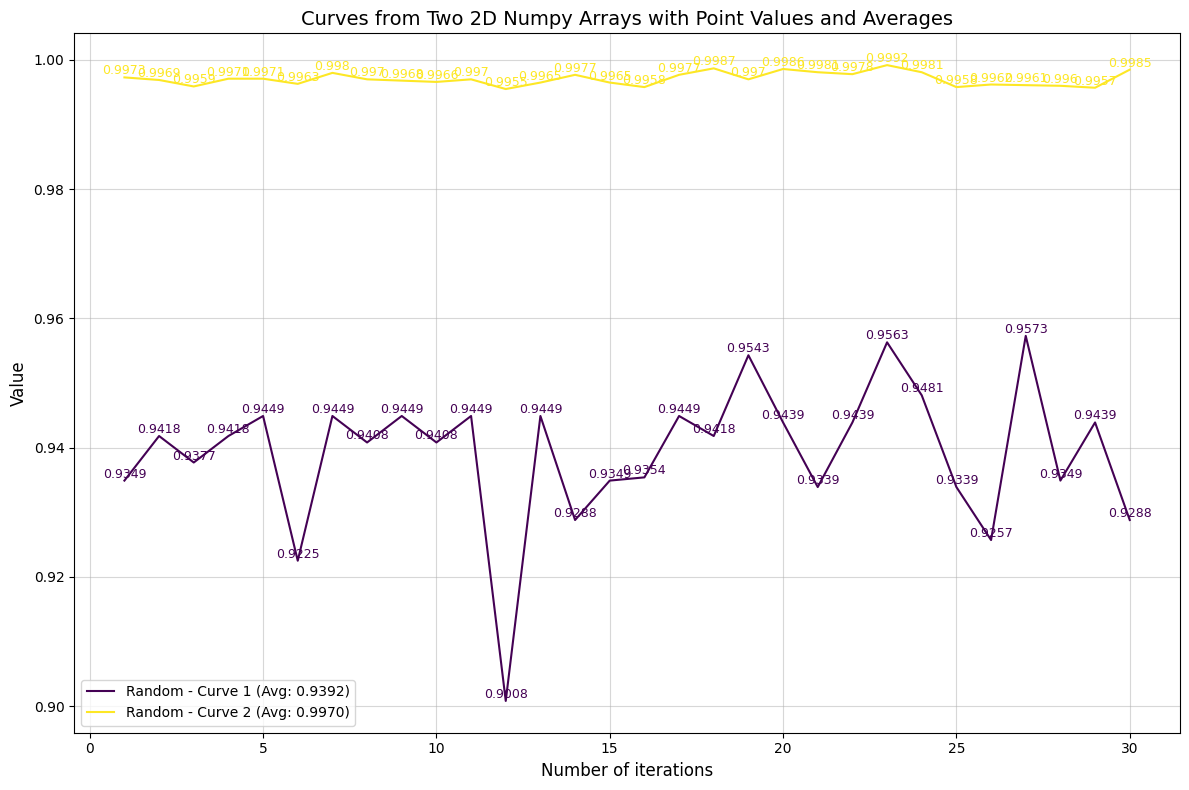

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Example data
data1 = np.round(np.array(ensembles_results).T, 4)

datasets = [data1]
colors1 = plt.cm.viridis(np.linspace(0, 1, len(data1)))

plt.figure(figsize=(12, 8))

# Plot Dataset 1
for i, (curve, color) in enumerate(zip(data1, colors1)):
    x = np.arange(1, len(curve) + 1)
    y = curve
    avg = np.mean(y)
    plt.plot(x, y, label=f'Random - Curve {i + 1} (Avg: {avg:.4f})', color=color)
    for xi, yi in zip(x, y):
        plt.text(xi, yi, f'{yi}', fontsize=9, ha='center', va='bottom', color=color)

# Plot settings
plt.title('Curves from Two 2D Numpy Arrays with Point Values and Averages', fontsize=14)
plt.xlabel('Number of iterations', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.5)
plt.tight_layout()

save_path = 'C:\\Users\\zsc\\Desktop\\evolution computation\\meeting\\2025.1.8\\e-mosaic\\' + datasetname + '\\'
# 创建文件夹（如果不存在）
folder = os.path.dirname(save_path)
if not os.path.exists(folder):
    os.makedirs(folder)
# Show plot
plt.savefig(save_path + datasetname + f'ensemble_gmean_mauc.jpg', dpi=300, bbox_inches='tight')